In [2]:
# How does change in the number of features effect calibration methods
# Change in the number of features -> change in the divercity of scores for tree(and possible RF) -> change in calib results

In [3]:
# imports
import sys
import pandas as pd
import numpy as np
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import Data.data_provider as dp
import core as cal
from estimators.IR_RF_estimator import IR_RF

In [4]:
# params
calib_methods = ["RF", "Platt" , "ISO", "Rank", "CRF", "VA", "Beta", "Elkan", "tlr"]
metrics = ["acc", "auc", "brier", "ece", "logloss"]
# calib_methods = ["RF", "Platt"]
# metrics = ["acc"]


data_name = "Sـfeatures"


params = {
    "runs": 3,
    "features": [2, 4, 6, 10, 20, 40, 80, 100], # as percentage of the x_calib data
    "data_size": 1000,
    "n_estimators": 10,
    "oob": False,
    "test_split": 0.3,
    "calib_split": 0.5
}

In [5]:
data_list = []
calib_results_dict = {}

for exp_features in params["features"]:

    # Data
    exp_data_name = str(exp_features) # data_name + "_" + 
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  exp_data_name:", exp_data_name)
    data_list.append(exp_data_name)
    X, y, tp = dp.make_classification_gaussian_with_true_prob(params["data_size"], exp_features, 0)
    
    data_dict = {} # results for each data set will be saved in here.
    for seed in range(params["runs"]): # running the same dataset multiple times
        # split the data
        # print("--------------------------------- run ", seed)

        data = cal.split_train_calib_test(exp_data_name, X, y, params["test_split"], params["calib_split"], seed)

        # train model
        irrf = IR_RF(n_estimators=params["n_estimators"], oob_score=params["oob"], random_state=seed)
        irrf.fit(data["x_train"], data["y_train"])

        # calibration
        res = cal.calibration(irrf, data, calib_methods, metrics) # res is a dict with all the metrics results as well as RF probs and every calibration method decision for every test data point
        # print("res", res)
        data_dict = cal.update_runs(data_dict, res) # calib results for every run for the same dataset is aggregated in data_dict (ex. acc of every run as an array)
        # print("data_dict", data_dict)

    # print("exp_features {exp_features} data_dict\n", data_dict)

    calib_results_dict.update(data_dict) # merge results of all datasets together
# print("---------------------------------")
# print(f">>>>>> exp_features {exp_features} calib_results_dict\n", calib_results_dict)
# print("---------------------------------")


In [6]:
tables = cal.mean_and_ranking_table(calib_results_dict, metrics, calib_methods, data_list, mean_and_rank=False)
tables

{'acc':             RF     Platt       ISO      Rank       CRF        VA      Beta     Elkan       tlr
 Data                                                                                          
 2     0.470000  0.507778  0.484444  0.493333  0.470000  0.508889  0.507778  0.470000  0.503333
 4     0.570000  0.571111  0.568889  0.585556  0.570000  0.508889  0.567778  0.570000  0.550000
 6     0.560000  0.560000  0.555556  0.570000  0.560000  0.508889  0.551111  0.560000  0.541111
 10    0.640000  0.636667  0.640000  0.607778  0.640000  0.508889  0.634444  0.640000  0.623333
 20    0.717778  0.720000  0.708889  0.702222  0.717778  0.508889  0.711111  0.717778  0.706667
 40    0.778889  0.777778  0.780000  0.778889  0.778889  0.508889  0.775556  0.778889  0.758889
 80    0.807778  0.812222  0.815556  0.797778  0.807778  0.508889  0.808889  0.807778  0.797778
 100   0.850000  0.843333  0.840000  0.817778  0.850000  0.508889  0.851111  0.850000  0.830000,
 'auc':             RF     Platt

Text(0, 0.5, 'ECE')

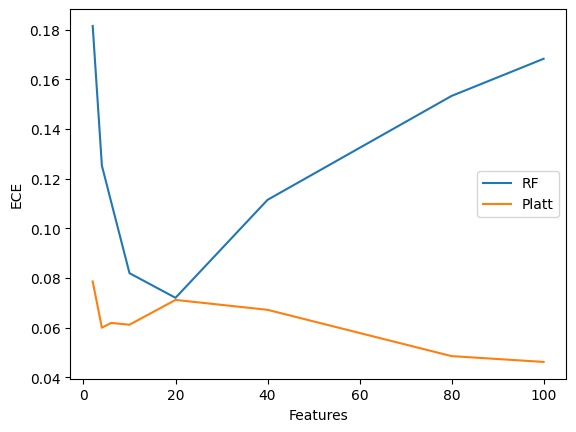

In [9]:
ax = tables["ece"][["RF", "Platt"]].plot()
ax.set_xlabel("Features")
ax.set_ylabel("ECE")

<Axes: xlabel='Data'>

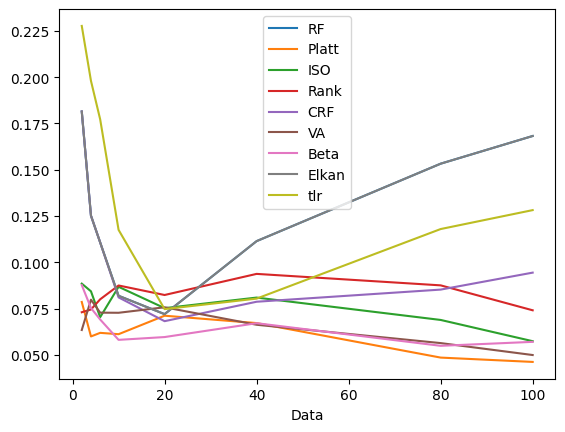

In [8]:
tables["ece"].plot()